# Ficando sem palavras

Nesse passo vamos trabalhar com palavras, aplicando-as em problemas de classificação, como análise de sentimento, e regressão, como a previsão de próxima palavra. Para processar palavras, precisamos de representá-las como vetores, esse process é chamado de [embedding](http://projector.tensorflow.org/).

In [1]:
# Importando dataset

# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [2]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.3.0


In [16]:
sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog'
]

tokenizer = Tokenizer(num_words=100, oov_token="OOV")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
word_index, pad_sequences(sequences, padding='post')

({'OOV': 1, 'cat': 6, 'dog': 5, 'i': 4, 'love': 2, 'my': 3, 'you': 7},
 array([[4, 2, 3, 5],
        [4, 2, 3, 6],
        [7, 2, 3, 5]], dtype=int32))

In [17]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [18]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

12 31 93 867 7 1256 6585 7961 421 365 2 26 14 9 988 1089 7 4 6728 6 276 5760 2587 2 81 6118 8029 2 139 1892 7961 5 5402 246 25 1 1771 350 5 369 56 5397 102 4 2547 3 4001 25 14 7822 209 12 3531 6585 7961 99 1 32 18 4762 3 19 184 3223 18 5855 1045 3 4232 3337 64 1347 5 1190 3 4459 8 614 7 3129 2 26 22 84 7020 6 71 18 4924 1160 161 50 2265 3 12 3983 2 12 264 31 2545 261 6 1 66 2 26 131 393 1 5846 6 15 5 473 56 614 7 1470 6
[  12   31   93  867    7 1256 6585 7961  421  365    2   26   14    9
  988 1089    7    4 6728    6  276 5760 2587    2   81 6118 8029    2
  139 1892 7961    5 5402  246   25    1 1771  350    5  369   56 5397
  102    4 2547    3 4001   25   14 7822  209   12 3531 6585 7961   99
    1   32   18 4762    3   19  184 3223   18 5855 1045    3 4232 3337
   64 1347    5 1190    3 4459    8  614    7 3129    2   26   22   84
 7020    6   71   18 4924 1160  161   50 2265    3   12 3983    2   12
  264   31 2545  261    6    1   66    2   26  131  393    1 5846    6
   15   

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 68s 87ms/step - loss: 0.5794 - accuracy: 0.6724 - val_loss: 0.4677 - val_accuracy: 0.7839
Epoch 2/50
782/782 [==============================] - 69s 88ms/step - loss: 0.3640 - accuracy: 0.8406 - val_loss: 0.4461 - val_accuracy: 0.7932
Epoch 3/50
782/782 [==============================] - 67s 86ms/step - loss: 0.2802 - accuracy: 0.8851 - val_loss: 0.4900 - val_accuracy: 0.7915
Epoch 4/50
782/782 [==============================] - 67s 85ms/step - loss: 0.2076 - accuracy: 0.9194 - val_loss: 0.6152 - val_accuracy: 0.7753
Epoch 5/50
782/782 [==============================] - 67s 86ms/step - loss: 0.1519 - accuracy: 0.9437 - val_loss: 0.6555 - val_accuracy: 0.7728
Epoch 6/50
782/782 [==============================] - 68s 87ms/step - loss: 0.1022 - accuracy: 0.9634 - val_loss: 0.8203 - val_accuracy: 0.7753
Epoch 7/50
782/782 [==============================] - 67s 85ms/step - loss: 0.0693 - accuracy: 0.9759 - val_loss: 0.9206 - val_accuracy:

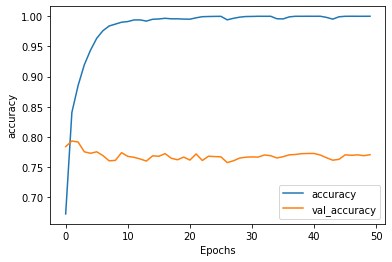

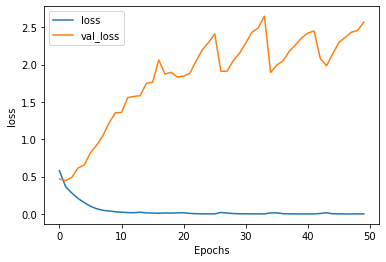

In [22]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 63s 81ms/step - loss: 0.5271 - accuracy: 0.7271 - val_loss: 0.4333 - val_accuracy: 0.8004
Epoch 2/50
782/782 [==============================] - 64s 81ms/step - loss: 0.3598 - accuracy: 0.8445 

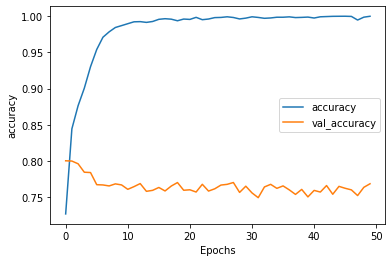

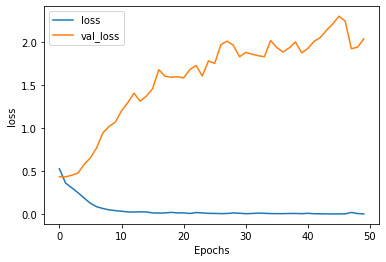

In [23]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


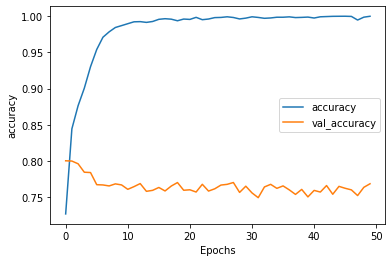

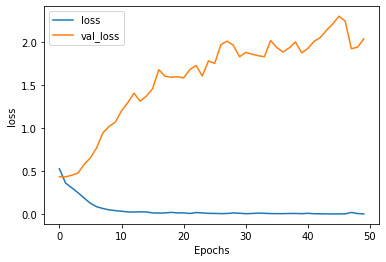

In [24]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')